In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import lightgbm as lgb

In [3]:
train_data = pd.read_csv("./train_data.csv")
test_data = pd.read_csv("./test_a.csv")

In [4]:
train_data = train_data.drop(["ID","city"],axis = 1)
test_data = test_data.drop(["ID","city"],axis = 1)

In [5]:
for df in [train_data,test_data]:
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')

In [6]:
for df in [train_data,test_data]:
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    df.drop('communityName',axis=1, inplace=True)

In [7]:
for df in [train_data,test_data]:
    # 将houseType转化为‘房间数’，‘厅数’，‘卫生间数’
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    df.insert(3,'室',None)
    df.insert(4, '厅', None)
    df.insert(5, '卫', None)
    df['室'] = df['houseType'].apply(parseRoom, index=0)
    df['厅'] = df['houseType'].apply(parseRoom, index=1)
    df['卫'] = df['houseType'].apply(parseRoom, index=2)
    
    df['交易月份'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
#     df['pv/uv'] = df['pv'] / df['uv']
#     df['房间总数'] = df['室'] + df['厅'] + df['卫']
    
    df.drop('houseType', axis=1, inplace=True)
    df.drop('tradeTime', axis=1, inplace=True)

### 简单数据清洗

In [8]:
train_data = train_data[train_data['area']<=700]
train_data = train_data[train_data['tradeMoney']<=100000]

In [9]:
columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']
for col in columns:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

In [10]:
train = train_data.drop(["tradeMoney"],axis = 1)
target = train_data["tradeMoney"]

In [11]:
test = test_data

In [12]:
features = train.columns

In [13]:
categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']

In [14]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [15]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])# categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1462.58	valid_1's rmse: 1442.63
[1000]	training's rmse: 1282.66	valid_1's rmse: 1408.15
[1500]	training's rmse: 1178.74	valid_1's rmse: 1398.69
Early stopping, best iteration is:
[1778]	training's rmse: 1135.67	valid_1's rmse: 1392.04
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1366.81	valid_1's rmse: 1955.11
[1000]	training's rmse: 1197.58	valid_1's rmse: 1898.46
[1500]	training's rmse: 1098.36	valid_1's rmse: 1876.01
[2000]	training's rmse: 1029.58	valid_1's rmse: 1864.47
[2500]	training's rmse: 976.083	valid_1's rmse: 1857.66
[3000]	training's rmse: 931.962	valid_1's rmse: 1852.53
[3500]	training's rmse: 894.129	valid_1's rmse: 1849.51
[4000]	training's rmse: 862.133	valid_1's rmse: 1847.31
[4500]	training's rmse: 833.002	valid_1's rmse: 1845.27
Early stopping, best iteration is:
[4676]	training's rmse: 823.528	valid_1's rmse: 1844.85
fold 2
T

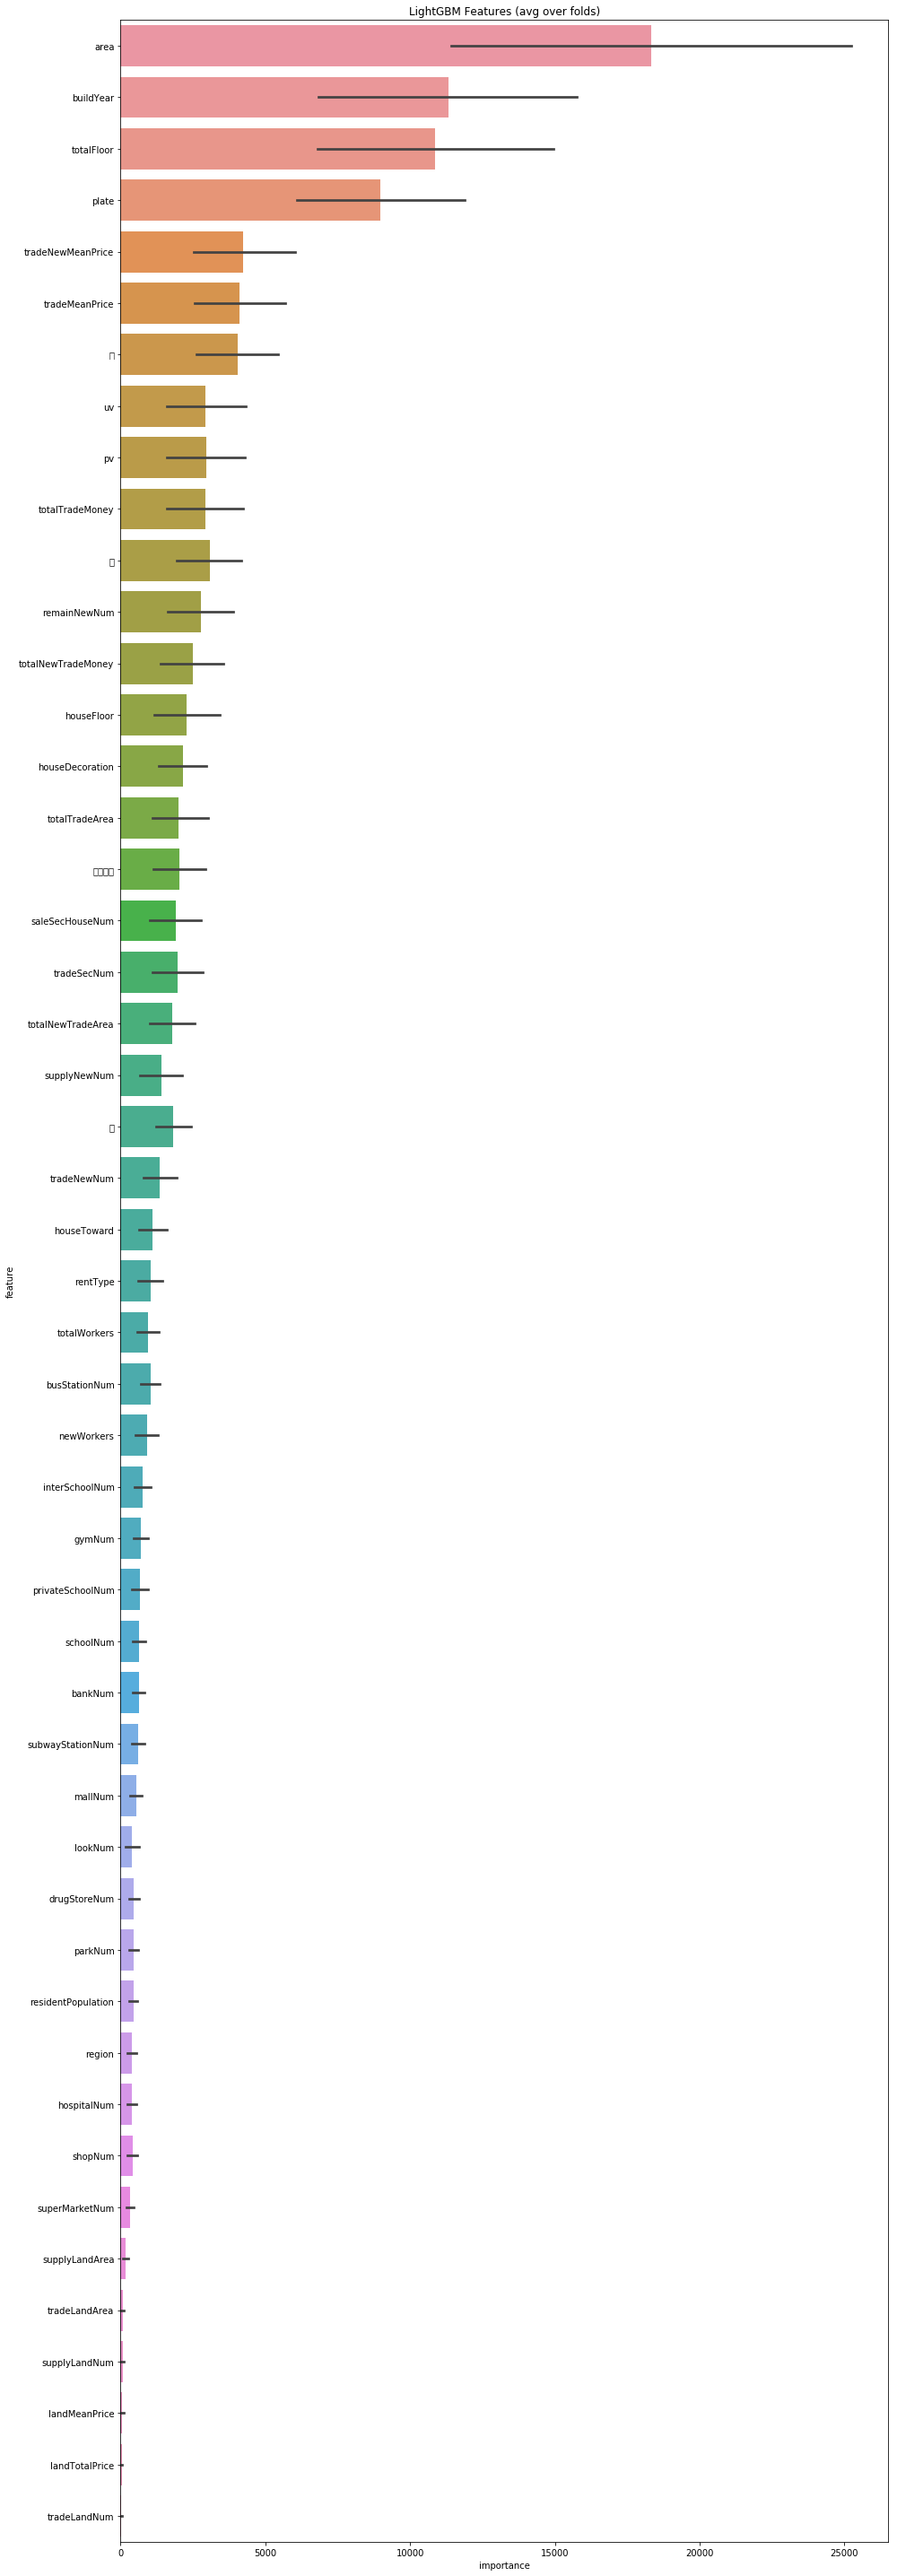

In [16]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [17]:
from sklearn.metrics import r2_score
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("./label.csv",engine = "python")#,header=None)
    score1 = r2_score(pred, conmbine1)
    print(score1)
    return score1
#     # b榜测分
#     conmbine3 = pd.read_csv("D:/城市-房产租金预测/best_result/sub_b_9194.csv",engine = "python",header=None)
#     score3= r2_score(pred, conmbine3)
#     print("对比919分数:{}".format(score3))

In [18]:
online_score(predictions_lgb)

预测结果最大值：18057.96951525739,预测结果最小值：1232.2295280870085
0.9445732477545664


0.9445732477545664